This code generates several scenarios that may be encountered in real life.

0. All nodes honest

1. One node misreports its coordinates while reporting (self-contradictory) accurate distances
2. One node misreports its distances to peers
3. One node misreports its coordinates while reporting false distances that match the false coordinates
4. One node claims to be in a location it is not, and no other nodes can see it
5. A group of nodes claim to be in a location they are not
6. Two nodes collude- one node is totally honest, except for the fact that it confirms dishonest metrics from another.
7. A group of nodes do the above
8. One node misreports its coordinates, misreports its own measurements to other nodes, and manipulates its responses to other nodes by delaying them and looking like it is further away from them than it really is

Output: 
- A $n \times n$ distances matrix $D$ where $D_{ij}$ is $i$'s  measurement of $j$, and vice versa.
- A $n \times 2$ coordinates matrix $C$ where $C_i$ is $[ x, y ]$ for node $i$

This data will contain the falsehoods injected by the dishonest nodes. In real life this data will be collected as submissions of peer measurements and coordinates from each node, but since they will probably be analyzed in this format, we will skip the round trip into the wire format.

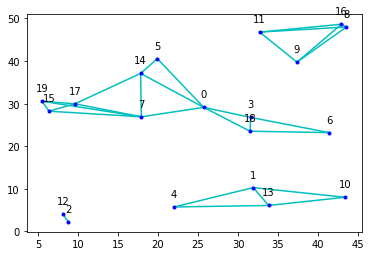

In [7]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

FIELD_SIZE = 50
NUM_NODES = 20
MAX_DISTANCE = 13

def generate_points():
#     xy = np.random.normal(0.5, 0.25, size=(2, numNodes)) * fieldSize
    xy = np.random.uniform(size=(2, NUM_NODES)) * FIELD_SIZE
    points = np.column_stack(xy)
    return points

def plot_points(points):
    # Put data in format preffered by plot
    xy = np.array([points[0:, 0], points[0:, 1]])
    
    # plot connections
    kdTree = spatial.cKDTree(points)
    pairs = list(kdTree.query_pairs(MAX_DISTANCE))

    def connectpoints(x,y,p1,p2):
        x1, x2 = x[p1], x[p2]
        y1, y2 = y[p1], y[p2]
        plt.plot([x1,x2],[y1,y2],'c-')

    for i in pairs:
        connectpoints(xy[0], xy[1], i[0], i[1])
    
    # plot points
    plt.plot(xy[0], xy[1], 'b.')
    
    # plot labels
    label = 0
    for x, y in zip(xy[0], xy[1]):
        plt.annotate(label, # this is the text
                     (x, y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        label = label + 1

def make_dist_matrix(points, randomize=False):
    kdTree = spatial.cKDTree(points)
    dists = kdTree.sparse_distance_matrix(kdTree, MAX_DISTANCE)
    dists = dists.toarray()
    
    # Randomize distances matrix (or not)
    if randomize: 
        dists = dists * np.random.normal(1, 0.1, dists.shape)
        
    return dists

def make_honest():
    C = generate_points()
    D = make_dist_matrix(C)
    plot_points(C)
    
    return {"C": C, "D": D}

honest = make_honest()

plt.show()

dishonest index: 17
honest coordinates: [ 9.62927399 29.93903552]
dishonest coordinates: [ 7.58107595 31.48928265]


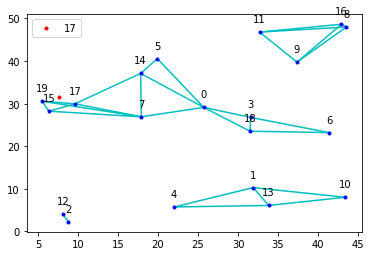

In [12]:
def make_dishonest1(C, D, minpeer=4, dishonesty=0.1):
    _C = np.copy(C)
    _D = np.copy(D)
    
    # Choose random node with more than minpeer peers
    nz = np.count_nonzero(_D, axis=1)
    nz = np.where(nz >= minpeer)[0]
    i = nz[np.random.randint(0, nz.size)]
    
    # Offset node by random offsets scaled to field size and desired amount of dishonesty
    xrand = FIELD_SIZE * np.random.normal(0, 0.1)
    yrand = FIELD_SIZE * np.random.normal(0, 0.1)
    _C[i] = np.array([_C[i][0] + xrand, _C[i][1] + yrand])
    
    print("dishonest index:", i)
    print("honest coordinates:", honest["C"][i])
    print("dishonest coordinates:", _C[i])
    
    plot_points(C)
    plt.plot(_C[i][0], _C[i][1], 'r.', label=i)
    plt.legend()
    
    return {"C": _C, "D": _D, "i": i}

dishonest1 = make_dishonest1(honest["C"], honest["D"])

plt.show()


In [ ]:
def make_dishonest2(C, D, minpeer=4, dishonesty=0.1):
    _C = np.copy(C)
    _D = np.copy(D)
    
    # Choose random node with more than minpeer peers
    nz = np.count_nonzero(_D, axis=1)
    nz = np.where(nz >= minpeer)[0]
    i = nz[np.random.randint(0, nz.size)]
    
#     # Offset node by random offsets scaled to field size and desired amount of dishonesty
#     xrand = FIELD_SIZE * np.random.normal(0, 0.1)
#     yrand = FIELD_SIZE * np.random.normal(0, 0.1)
#     _C[i] = np.array([_C[i][0] + xrand, _C[i][1] + yrand])
    
#     print("dishonest index:", i)
#     print("honest coordinates:", honest["C"][i])
#     print("dishonest coordinates:", _C[i])
    
#     plot_points(C)
#     plt.plot(_C[i][0], _C[i][1], 'r.', label=i)
#     plt.legend()
    
    return {"C": _C, "D": _D, "i": i}

dishonest1 = make_dishonest1(honest["C"], honest["D"])

plt.show()